In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 10})
from tqdm import tqdm
import utils
import NonlinearAlignment as na
from scipy.optimize import leastsq
from collections import defaultdict
from scipy.interpolate import InterpolatedUnivariateSpline

In [250]:
def Earth_gravity_model(sat_state, dt):
    
    """
    Calculates next point for generlized coordintes
    coord = np.array([x, y, z])
    speed = np.array([Vx, Vy, Vz])
    sat_state = np.array([x, y, z, Vx, Vy, Vz])
    dt - time step    
    """
    
    coord = sat_state[:3]
    speed = sat_state[3:]
    r = np.linalg.norm(coord)       # distance to satellite
    a_abs = (G * M) / (r ** 2)      # acceleration absolute value
    a = -(coord / r) * a_abs
    result_speed = speed + a * dt
    result_coord = coord + (speed + result_speed) / 2 * dt
    return np.concatenate([result_coord, result_speed])



def iterative_trajectory_modelling(model, start_state, t_simulation, dt):
    
    """
    Iterating Earth_gravity_model or other function with same interface
    """
    current_state = start_state
    for step in range(int(t_simulation/ dt)):
        current_state = model(sat_state=current_state, dt=dt)
    current_state = model(current_state, dt=t_simulation % dt)
    return current_state


def inverse_iterative_trajectory_modelling(model, start_state, t_simulation, dt=1):
    """
    predicting past states
    """
    start_state[3:] *= -1
    end_state = iterative_trajectory_modelling(model, start_state, t_simulation, dt)
    end_state[3:] *= -1
    return end_state


def time_state(row):
    time = row['epoch']
    state = row[state_cols].values
    return time, state

def predict_segment(begin_row, end_row, t_new, dt):
    """
    Predicts generalized coordinates for the future or the past 
    using Eath Gravity Model
    """
    
    pred = defaultdict(lambda: {})
    if begin_row is not None:
        current_t, current_state = begin_t, begin_state = time_state(begin_row)
        for t in t_new:
            if t >= current_t:
                current_state = iterative_trajectory_modelling(
                    Earth_gravity_model, current_state * 1000, (t - current_t) / 10 ** 9,
                    dt=dt) / 1000
                current_t = t
                pred[current_t]['forward'] = {'pred': current_state, 'sim_duration': current_t - begin_t}
                
    if end_row is not None:
        current_t, current_state = end_t, end_state = time_state(end_row)
        for t in t_new[::-1]:
            if t <= current_t:
                current_state = inverse_iterative_trajectory_modelling(
                    Earth_gravity_model, current_state * 1000, (current_t - t) / 10 ** 9,
                    dt=dt) / 1000
                current_t = t
                pred[current_t]['backward'] = {'pred': current_state, 'sim_duration': end_t - current_t}
                
    segment_df = []
    for t in sorted(pred.keys()):
        assert len(pred[t]) > 0
        t_pred = np.zeros(6)
        t_weights_sum = 0
        
        for simulation, simulation_res in pred[t].items():
            assert simulation_res['sim_duration'] >= 0
            weight = 1 / (simulation_res['sim_duration'] + 1)
            t_pred += simulation_res['pred'] * weight
            t_weights_sum += weight
            
        segment_df.append(np.concatenate([[t], t_pred / t_weights_sum]))
    return segment_df

def sparse_pred_to_dense(sparse_sat_data, t_new, dt):
    """
    Fill the values in points between the sparse data
    """
    
    result = []
    first_row = sparse_sat_data.iloc[0]
    # predict before the first sparse point
    result.extend(predict_segment(None, first_row, t_new[t_new < first_row['epoch']], dt=dt))
    
    for row_id in range(len(sparse_sat_data) - 1):
        begin_row = sparse_sat_data.iloc[row_id]
        end_row = sparse_sat_data.iloc[row_id + 1]
        segment = t_new[(t_new >= begin_row['epoch']) & (t_new < end_row['epoch'])]
        result.extend(predict_segment(begin_row, end_row, segment, dt=dt))
    result.extend(predict_segment(end_row, None, t_new[t_new >= end_row['epoch']], dt=dt))
    return pd.DataFrame(result, columns=['t',] + state_cols)


def get_key_points(t, x):
    
    """
    Basic function used in ZeroKeypointsGenerator
    finding t: x(t)=0 and filtering the outliers
    """
    spl = InterpolatedUnivariateSpline(t, x)
    roots = spl.roots()
    key_points = roots[1::2]
    if len(key_points) < 3:
        return key_points, np.zeros_like(key_points)
    
    outlier_scores = np.abs((key_points[2:] + key_points[:-2] - 2 * key_points[1:-1]) /
                             key_points[1:-1])
    np.pad(np.abs((key_points[2:] + key_points[:-2] - 2 * key_points[1:-1]) /
                             key_points[1:-1]), (2, 2), mode = 'constant',constant_values=1)
    
    threshold = 3 * np.percentile(outlier_scores, 75) - 2 * np.percentile(outlier_scores, 25)
    outliers = (np.convolve(np.pad(outlier_scores > threshold, (2, 2),mode = 'constant',constant_values=1), [1, 1, 1]) == 3)[2:-2]
    return key_points, outliers


def linear_params(t, x):
    model_func = lambda params, t: (params[0] * t + params[1])
    a = (x[-1] - x[0]) / (t[-1] - t[0])
    b = x[0] - a * t[0]
    init_params = (a, b)
    return model_func, init_params


def sinusoid_plus_linear_params(t, x):
    model_func = lambda params, t: (params[0] *
                                    np.sin(params[1] * t + params[2]) +
                                    params[3] + t * params[4])
    init_params = (np.std(x), 1/(t[-1] - t[0]), 0, np.mean(x), (x[-1] - x[0]) / (t[-1] - t[0]))
    return model_func, init_params

def pick_model_function(t, x):
    """
    Selects linear or sinusoid + linear function 
    based on the number of time point
    """
#     print(len(t))
    if len(t) >= 10:
        return sinusoid_plus_linear_params(t, x)
    else:
        return linear_params(t, x)

def fit_curve(t, x, model_func, init_params):
    def optimize_func(params):
        return model_func(params, t) - x

    ls_params = leastsq(optimize_func, init_params)[0]
    return lambda x: model_func(ls_params, x)

class ZeroKeypointsGenerator:
    def __init__(self, anchor_feature):
        self.anchor_feature = anchor_feature
    
    def get_sim_keypoints(self, sat_data):
        return get_key_points(sat_data['epoch'], sat_data[self.anchor_feature + '_sim'])
    
    def get_gt_keypoints(self, sat_data):
        return get_key_points(sat_data['epoch'], sat_data[self.anchor_feature])
    

class ShiftZeroKeypointsGenerator:
    """
    Generating a lattice of keypoints (shifted from the roots of X(t)
    by a portion of the oscillation period)
    """
    def __init__(self, anchor_feature, alpha=1):
        self.anchor_feature = anchor_feature
        self.alpha = alpha
    
    def get_sim_keypoints(self, sat_data):
        kp, outliers = get_key_points(sat_data['epoch'], sat_data[self.anchor_feature + '_sim'])
        outliers = outliers[1:] | outliers[:-1]
        period = kp[1:] - kp[:-1]
        return kp[:-1] + period * self.alpha, outliers
    
    def get_gt_keypoints(self, sat_data):
        kp, outliers = get_key_points(sat_data['epoch'], sat_data[self.anchor_feature])
        outliers = outliers[1:] | outliers[:-1]
        period = kp[1:] - kp[:-1]
        return kp[:-1] + period * self.alpha, outliers
    
    
def sine_alignment(sat_data, sat_id, kp_generator, train_t_max):
    """
    Performs nonlinear stretching of the coordinates
    """
    
    train_sat_data = sat_data[sat_data['epoch'] <= train_t_max]    
    all_sim_kp, all_sim_kp_outliers = kp_generator.get_sim_keypoints(sat_data)
    
    # broken simulation handling
    if sat_id == 481:
        pred = sat_data[sat_data['epoch'] > train_t_max][['epoch'] + [c + '_sim' for c in state_cols]]
        pred.columns =  ['t'] + state_cols
        return pred
        
    train_gt_kp, train_gt_kp_outliers = kp_generator.get_gt_keypoints(train_sat_data)
    
    stretch_data = all_sim_kp[:len(train_gt_kp)], train_gt_kp
    if len(train_gt_kp) >= 5:
        use_kp = ~(all_sim_kp_outliers[:len(train_gt_kp)] | train_gt_kp_outliers)
        stretch_data = (stretch_data[0][use_kp], stretch_data[1][use_kp])
    time_stretch_function = fit_curve(*stretch_data,
                                      *pick_model_function(all_sim_kp[:len(train_gt_kp)], train_gt_kp))

    
    keypoints = time_stretch_function(all_sim_kp)
    train_keypoints = keypoints[keypoints < train_t_max]
    test_keypoints = keypoints[len(train_keypoints):]
    
    
    
    sim_stretched_t = time_stretch_function(sat_data['epoch'])
#    train_sim_stretched_t = sim_stretched_t[:len(train_sat_data)]
    
    pred = []
#    gt = []
    for feature in state_cols:
        sim_feature = feature + '_sim'

        
        # values of simulation at all key points
        all_kp_sim_feature = utils.resample(t=sim_stretched_t.values,
                                              x=sat_data[sim_feature].values,
                                              t_new=keypoints)
        # values of simulation at train key points
        train_kp_sim_feature = all_kp_sim_feature[:len(train_keypoints)]
        
        # ground truth values at train key points
        train_kp_gt_feature = utils.resample(t=train_sat_data['epoch'],
                                             x=train_sat_data[feature],
                                             t_new=train_keypoints)

        # difference between train and ground truth at train keypoints
        train_diff = train_kp_gt_feature - train_kp_sim_feature
#         kp_diff_func = lambda x: np.ones_like(x) * np.mean(train_diff)
        kp_diff_func = fit_curve(train_keypoints, train_diff,
                                  *linear_params(train_keypoints, train_diff))
        pred_kp_diff = kp_diff_func(test_keypoints)


        pred.append(pred_kp_diff + all_kp_sim_feature[len(train_keypoints):])
    pred_df = pd.DataFrame(np.array(pred), index=state_cols).T
    pred_df['epoch'] = test_keypoints
    return pred_df

def sine_alignment_part(sat_data, sat_id, kp_generator, train_t_max,train_t_min = 0):
    '''
    Args:
    sat_id
    kp_generator = instance of ShiftZeroKeypointsGenerator class
    train_t_max = max time to train on
    
    
    '''
#    sat_data = utils.get_satellite_data(data, sat_id).reset_index(drop=True)
#    sat_data = utils.remove_time_jumps_fast(sat_data)
    
    train_sat_data = sat_data[sat_data['epoch'] <= train_t_max]
    m = int(train_t_min*train_sat_data.shape[0])
    train_sat_data = train_sat_data[m:]
    
    all_sim_kp, all_sim_kp_outliers = kp_generator.get_sim_keypoints(sat_data)
    # broken simulation handling
    if sat_id == 481:
        pred = sat_data[sat_data['epoch'] > train_t_max][['epoch'] + [c + '_sim' for c in state_cols]]
        pred.columns =  ['t'] + state_cols
        return pred
        
    train_gt_kp, train_gt_kp_outliers = kp_generator.get_gt_keypoints(train_sat_data)
    
    stretch_data = all_sim_kp[:len(train_gt_kp)], train_gt_kp #sim, followed by train  keypts
    if len(train_gt_kp) >= 5:
        use_kp = ~(all_sim_kp_outliers[:len(train_gt_kp)] | train_gt_kp_outliers)
        stretch_data = (stretch_data[0][use_kp], stretch_data[1][use_kp])
    time_stretch_function = fit_curve(*stretch_data,
                                      *pick_model_function(all_sim_kp[:len(train_gt_kp)], train_gt_kp)) # ln=False
    
    keypoints = time_stretch_function(all_sim_kp)
    train_keypoints = keypoints[keypoints < train_t_max]
    test_keypoints = keypoints[len(train_keypoints):]
    
    sim_stretched_t = time_stretch_function(sat_data['epoch'])
#    train_sim_stretched_t = sim_stretched_t[:len(train_sat_data)]
    
    pred = []
#    gt = []
    for feature in state_cols:
        sim_feature = feature + '_sim'

        
        # values of simulation at all key points
        all_kp_sim_feature = utils.resample(t=sim_stretched_t.values,
                                              x=sat_data[sim_feature].values,
                                              t_new=keypoints)
        # values of simulation at train key points
        train_kp_sim_feature = all_kp_sim_feature[:len(train_keypoints)]
        
        # ground truth values at train key points
        train_kp_gt_feature = utils.resample(t=train_sat_data['epoch'],
                                             x=train_sat_data[feature],
                                             t_new=train_keypoints)

        # difference between train and ground truth at train keypoints
        train_diff = train_kp_gt_feature - train_kp_sim_feature
#         kp_diff_func = lambda x: np.ones_like(x) * np.mean(train_diff)
        kp_diff_func = fit_curve(train_keypoints, train_diff,
                                  *linear_params(train_keypoints, train_diff))
        pred_kp_diff = kp_diff_func(test_keypoints)


        pred.append(pred_kp_diff + all_kp_sim_feature[len(train_keypoints):])
    pred_df = pd.DataFrame(np.array(pred), index=state_cols).T
    pred_df['epoch'] = test_keypoints
    return pred_df


### Load the data

In [3]:
data = pd.read_csv('data/train.csv', index_col= 'id')
data.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [4]:
np.random.seed(50)
coord_cols = ['x', 'y', 'z']
speed_cols = ['Vx', 'Vy', 'Vz']
state_cols = coord_cols + speed_cols

print('Loading data...')
train_data = pd.read_csv('data/train.csv', index_col='id')
train_data['epoch'] = pd.to_datetime(train_data['epoch']).values.astype(float)

test_data = pd.read_csv('data/test.csv', index_col='id')
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)

data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)
print('Data loaded.')


Loading data...
Data loaded.


In [400]:
sat_id = 6
sat_data = utils.get_satellite_data(data, sat_id).reset_index(drop=True)
sat_data = utils.remove_time_jumps_fast(sat_data)
train_t = utils.get_satellite_data(train_data, sat_id)['epoch']
test_t = utils.get_satellite_data(test_data, sat_id)['epoch']

train_sat_data = sat_data[sat_data['epoch'] <= train_t.max()]    
all_sim_kp, all_sim_kp_outliers = na.ShiftZeroKeypointsGenerator('x',0.01).get_sim_keypoints(sat_data)

In [401]:
train_gt_kp, train_gt_kp_outliers = na.ShiftZeroKeypointsGenerator('x',0.01).get_gt_keypoints(train_sat_data)
stretch_data = all_sim_kp[:len(train_gt_kp)], train_gt_kp

In [402]:
all_sim_kp_n = ((pd.to_datetime(all_sim_kp) - pd.to_datetime(all_sim_kp)[0]) /
                 np.timedelta64(1, 'D')).astype(float) 
train_gt_kp_n = ((pd.to_datetime(train_gt_kp) - pd.to_datetime(train_gt_kp)[0]) /
                 np.timedelta64(1, 'D')).astype(float) 
t = ((pd.to_datetime(train_sat_data['epoch']) - pd.to_datetime(train_sat_data['epoch'])[0]) /
                 np.timedelta64(1, 'D')).astype(float)

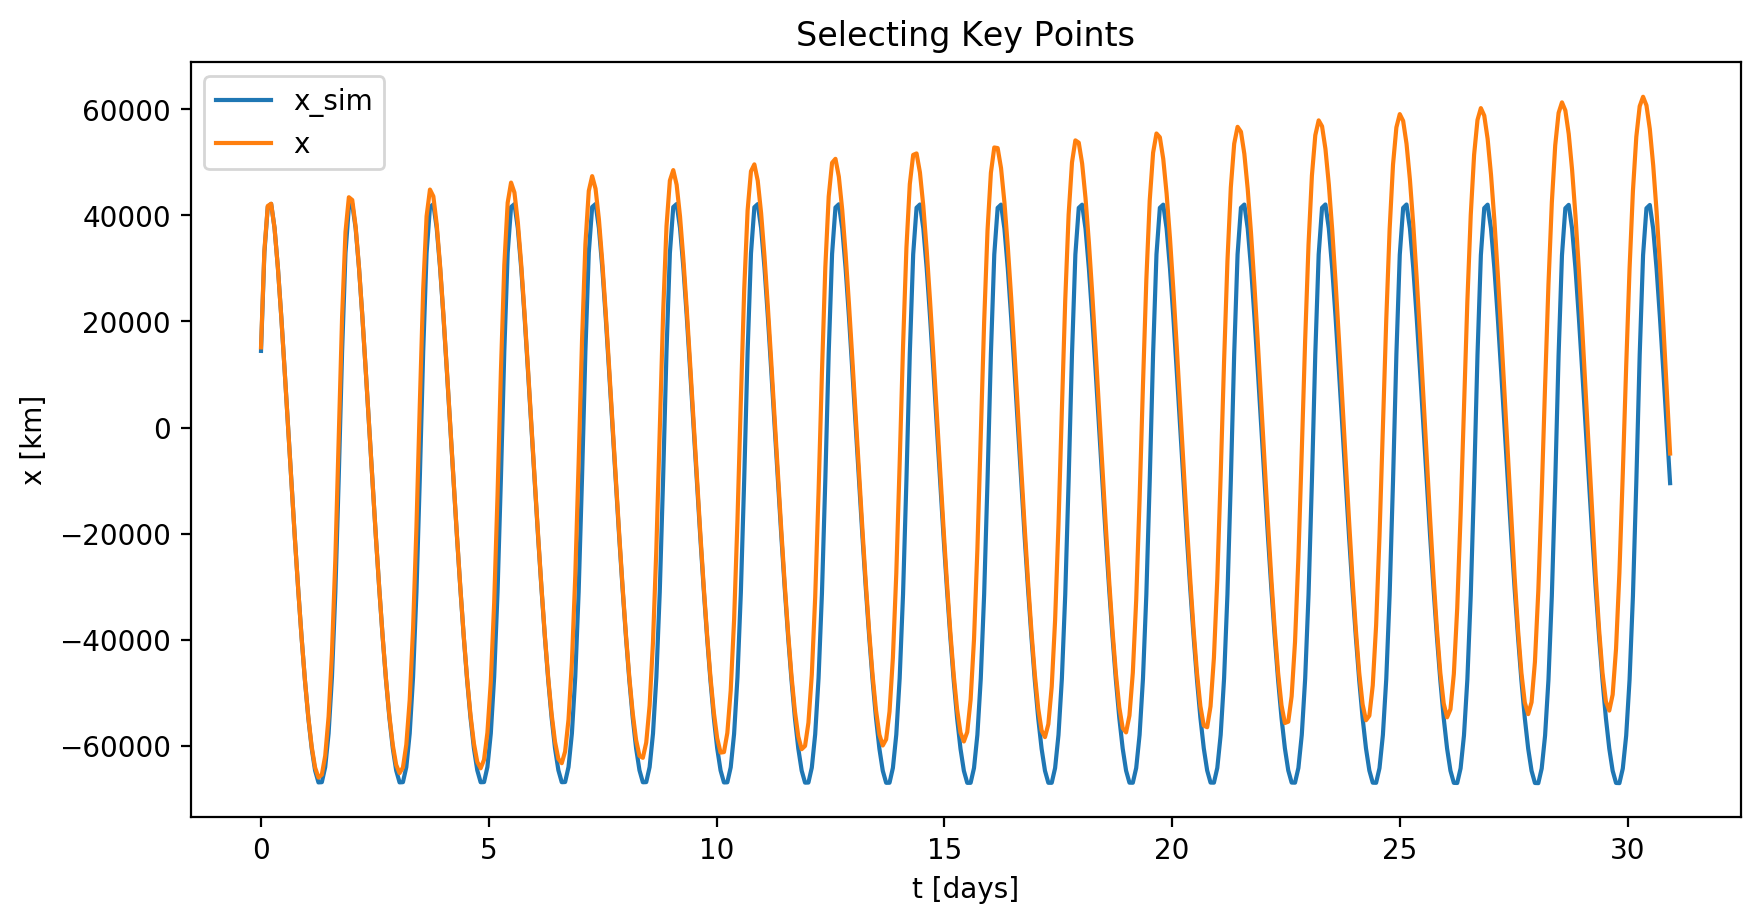

In [403]:
plt.figure(figsize = (10,5), dpi = 200)
plt.plot(t, train_sat_data.x_sim, label = 'x_sim')
plt.plot(t, train_sat_data.x, label = 'x')
# plt.scatter(all_sim_kp_n[:len(train_gt_kp)],[10000]*len(train_gt_kp), label = 'x_sim')
# plt.scatter(train_gt_kp_n,[10000]*len(train_gt_kp), label = 'x')
_ = plt.legend()
_ = plt.xlabel('t [days]')
_ = plt.ylabel('x [km]')
_ = plt.title('Selecting Key Points')


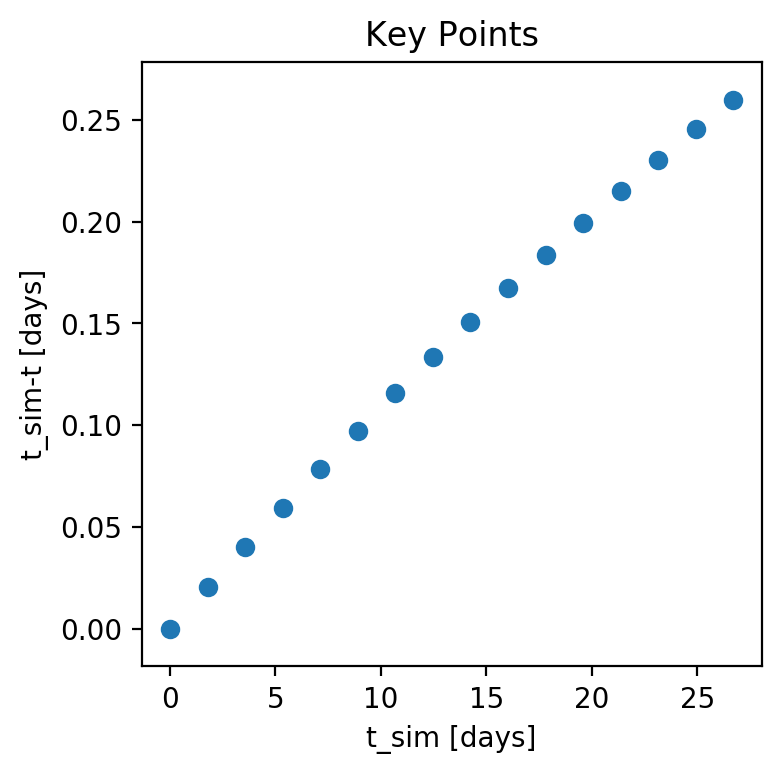

In [404]:
plt.figure(figsize = (4,4), dpi = 200)
plt.scatter(all_sim_kp_n[:len(train_gt_kp)],all_sim_kp_n[:len(train_gt_kp)]-train_gt_kp_n)

_ = plt.xlabel('t_sim [days]')
_ = plt.ylabel('t_sim-t [days]')
_ = plt.title('Key Points')


In [405]:
# data.groupby(['sat_id'])['epoch'].count().sort_values()

In [406]:
time_stretch_function = fit_curve(*stretch_data,
                                      *pick_model_function(all_sim_kp[:len(train_gt_kp)], train_gt_kp))
keypoints = time_stretch_function(all_sim_kp)
train_keypoints = keypoints[keypoints <  train_t.max()]
test_keypoints = keypoints[len(train_keypoints):]

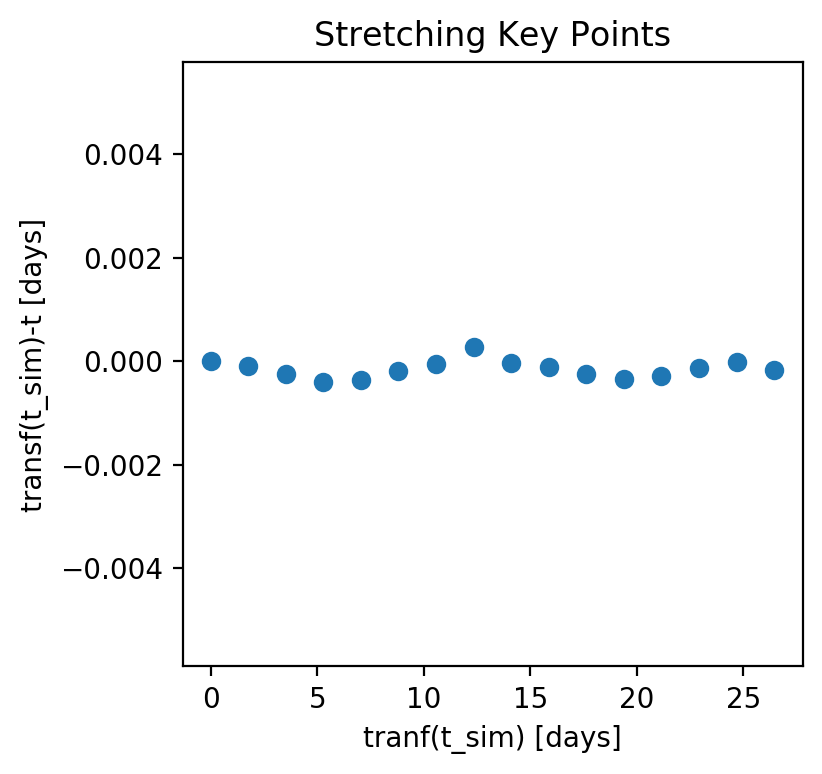

In [407]:
keypoints.sort()
keypoints_n = ((pd.to_datetime(keypoints) - pd.to_datetime(keypoints)[0]) /
                 np.timedelta64(1, 'D')).astype(float)
plt.figure(figsize = (4,4), dpi = 200)
# plt.scatter(all_sim_kp_n,all_sim_kp_n-keypoints_n)
plt.scatter(keypoints_n[:len(train_keypoints)-1],keypoints_n[:len(train_keypoints)-1]-train_gt_kp_n)
_ = plt.xlabel('tranf(t_sim) [days]')
_ = plt.ylabel('transf(t_sim)-t [days]')
_ = plt.title('Stretching Key Points')


In [408]:
len(train_gt_kp_n)

16

In [409]:
sim_stretched_t = time_stretch_function(sat_data['epoch'])
len(keypoints)
len(sim_stretched_t)
# sim_stretched_t

796

In [410]:
all_kp_sim_feature = utils.resample(t=sim_stretched_t.values,
                                              x=sat_data['x_sim'].values,
                                              t_new=keypoints)
keypoints_n = ((pd.to_datetime(keypoints) - pd.to_datetime(keypoints)[0]) /
                 np.timedelta64(1, 'D')).astype(float) 
# sim_stretched_t_n = ((pd.to_datetime(keypoints) - pd.to_datetime(keypoints)[0]) /
#                  np.timedelta64(1, 'D')).astype(float) 

# values of simulation at train key points
train_kp_sim_feature = all_kp_sim_feature[:len(train_keypoints)]

# ground truth values at train key points
train_kp_gt_feature = utils.resample(t=train_sat_data['epoch'],
                                     x=train_sat_data['x_sim'],
                                     t_new=train_keypoints)
train_keypoints_n = ((pd.to_datetime(train_keypoints) - pd.to_datetime(train_keypoints)[0]) /
                 np.timedelta64(1, 'D')).astype(float) 

In [411]:
train_diff = train_kp_gt_feature - train_kp_sim_feature
#         kp_diff_func = lambda x: np.ones_like(x) * np.mean(train_diff)
kp_diff_func = fit_curve(train_keypoints, train_diff,
                          *linear_params(train_keypoints, train_diff))
pred_kp_diff = kp_diff_func(train_keypoints)

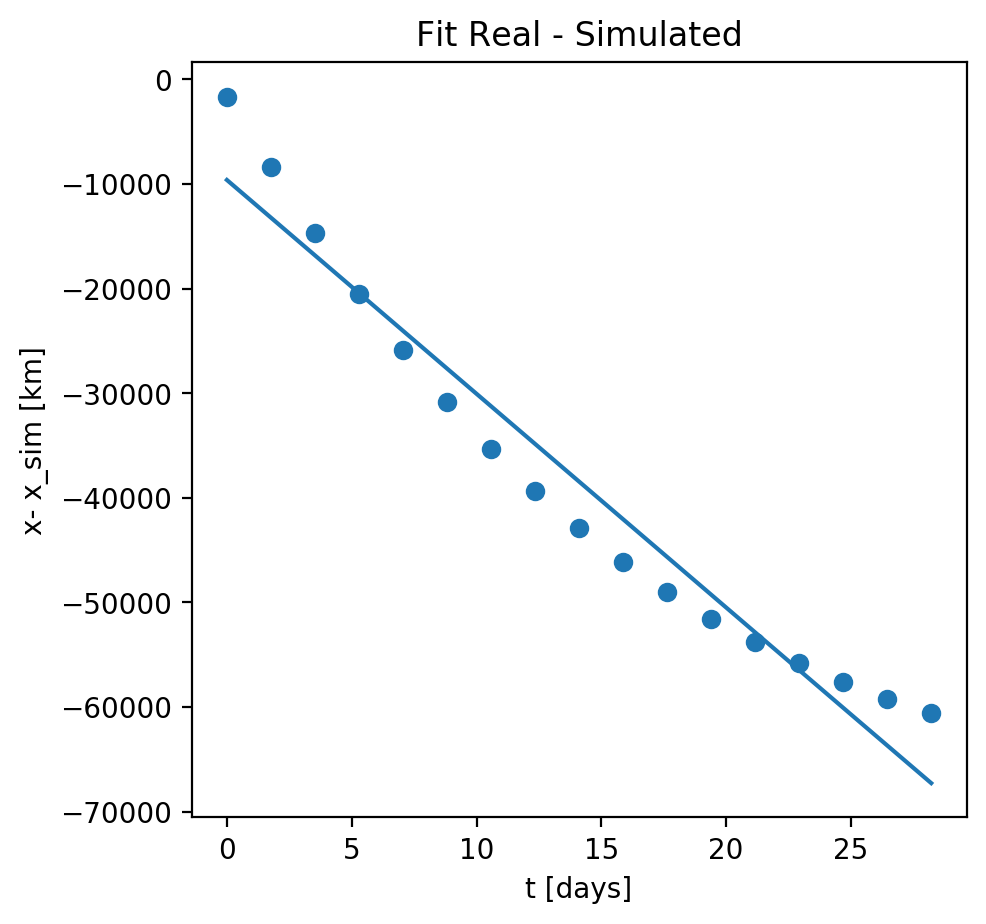

In [413]:
plt.figure(figsize = (5,5), dpi = 200)
# plt.scatter(train_keypoints_n, train_kp_sim_feature, label = 'x_sim')
plt.scatter(train_keypoints_n, train_kp_gt_feature, label = 'x')
plt.plot(train_keypoints_n,train_kp_sim_feature + pred_kp_diff)


_ = plt.xlabel('t [days]')
_ = plt.ylabel('x- x_sim [km]')
_ = plt.title('Fit Real - Simulated')

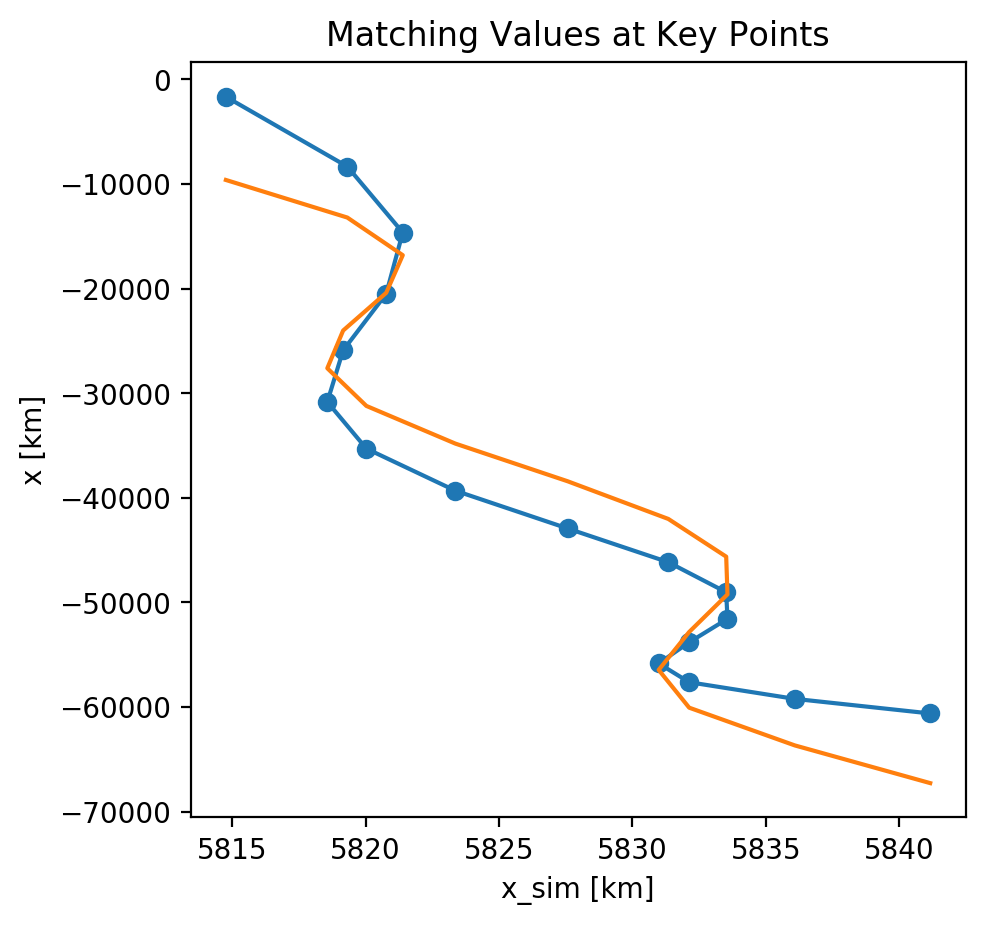

In [414]:
plt.figure(figsize = (5,5), dpi = 200)

plt.scatter(train_kp_sim_feature, train_kp_gt_feature)
plt.plot(train_kp_sim_feature, train_kp_gt_feature)
plt.plot(train_kp_sim_feature,train_kp_sim_feature + pred_kp_diff)
_ = plt.xlabel('x_sim [km]')
_ = plt.ylabel('x [km]')
_ = plt.title('Matching Values at Key Points')

In [337]:
pred_kp_diff = kp_diff_func(test_keypoints)
pred = pred_kp_diff + all_kp_sim_feature[len(train_keypoints):]
pred_df = pd.DataFrame(np.array(pred).T)
pred_df['epoch'] = test_keypoints

In [338]:
for sat_id in tqdm([6]):
    try:
        sat_data = utils.get_satellite_data(data, sat_id).reset_index(drop=True)
        sat_data = utils.remove_time_jumps_fast(sat_data)
        
        N = 4*len(utils.get_satellite_data(train_data, sat_id)['epoch'])//5
        train_t = utils.get_satellite_data(train_data, sat_id)['epoch'].iloc[:N]
        test_t = pd.concat([utils.get_satellite_data(train_data, sat_id)['epoch'].iloc[N:], utils.get_satellite_data(test_data, sat_id)['epoch'].iloc[:]])

        pred_dfs = []
        sparse_pred_dfs = []
        # running sine_alignment for different lattices:
        # different alphas and anchor features
        for anchor in state_cols:
            for alpha in np.linspace(0, 1, 100)[1:]:
                pred_df = na.sine_alignment(sat_data, sat_id, na.ShiftZeroKeypointsGenerator(anchor, alpha), train_t.max())
                sparse_pred_dfs.append(pred_df)
        sparse_pred = pd.concat(sparse_pred_dfs).sort_values('epoch').reset_index(drop=True)
        dense_pred = na.sparse_pred_to_dense(sparse_pred, test_t, dt=8)
        all_predictions_shiftzero_kp[sat_id] = dense_pred
    except Exception as e:
        print(e)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

name 'all_predictions_shiftzero_kp' is not defined


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:51<00:00, 51.91s/it]


In [282]:
test_t

id
16408    1.389175e+18
16409    1.389182e+18
16410    1.389188e+18
16411    1.389195e+18
16412    1.389201e+18
             ...     
17099    1.393604e+18
17100    1.393610e+18
17101    1.393617e+18
17102    1.393623e+18
17103    1.393630e+18
Name: epoch, Length: 696, dtype: float64

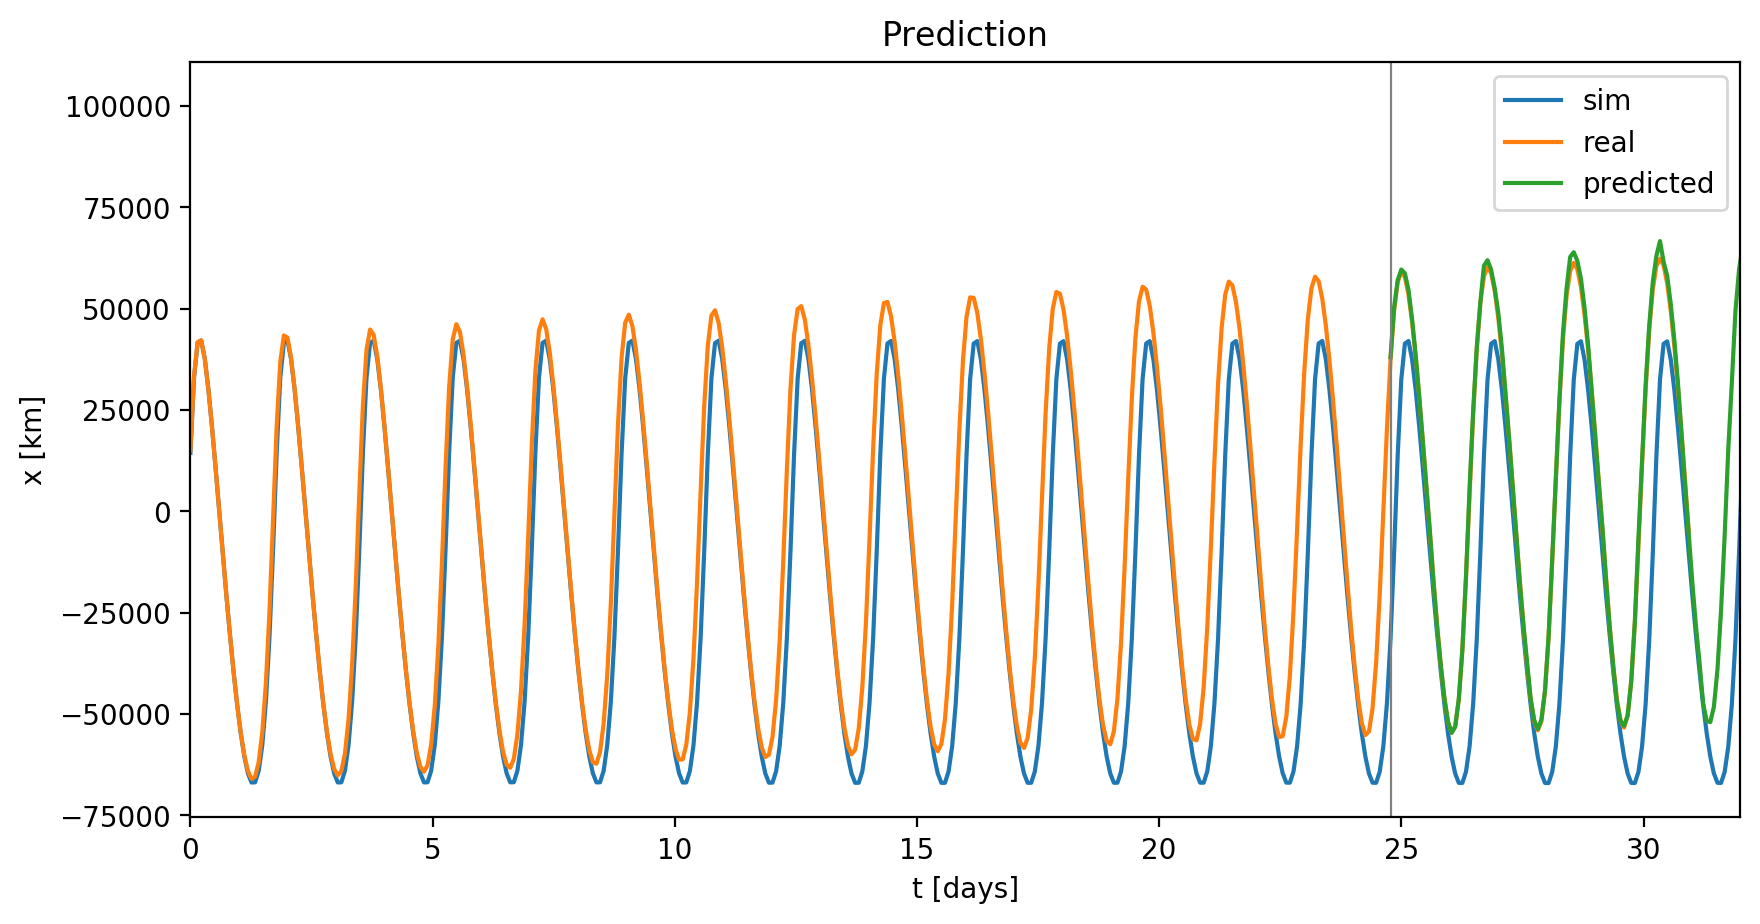

In [345]:
t = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch'])[0]) /
                 np.timedelta64(1, 'D')).astype(float)
plt.figure(figsize = (10,5), dpi = 200)
plt.plot(t, sat_data.x_sim, label = 'sim')
plt.plot(t[:len(sat_data.x)], sat_data.x, label = 'real')
plt.plot(t[len(train_t):], dense_pred.x, label ='predicted')
_ = plt.legend()
_ = plt.xlabel('t [days]')
_ = plt.ylabel('x [km]')
_ = plt.title('Prediction')
_ = plt.xlim([0,32])
_ = plt.axvline(x=t[len(train_t)], color = 'gray', linewidth = 0.8)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

name 'all_predictions_shiftzero_kp' is not defined


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.17s/it]


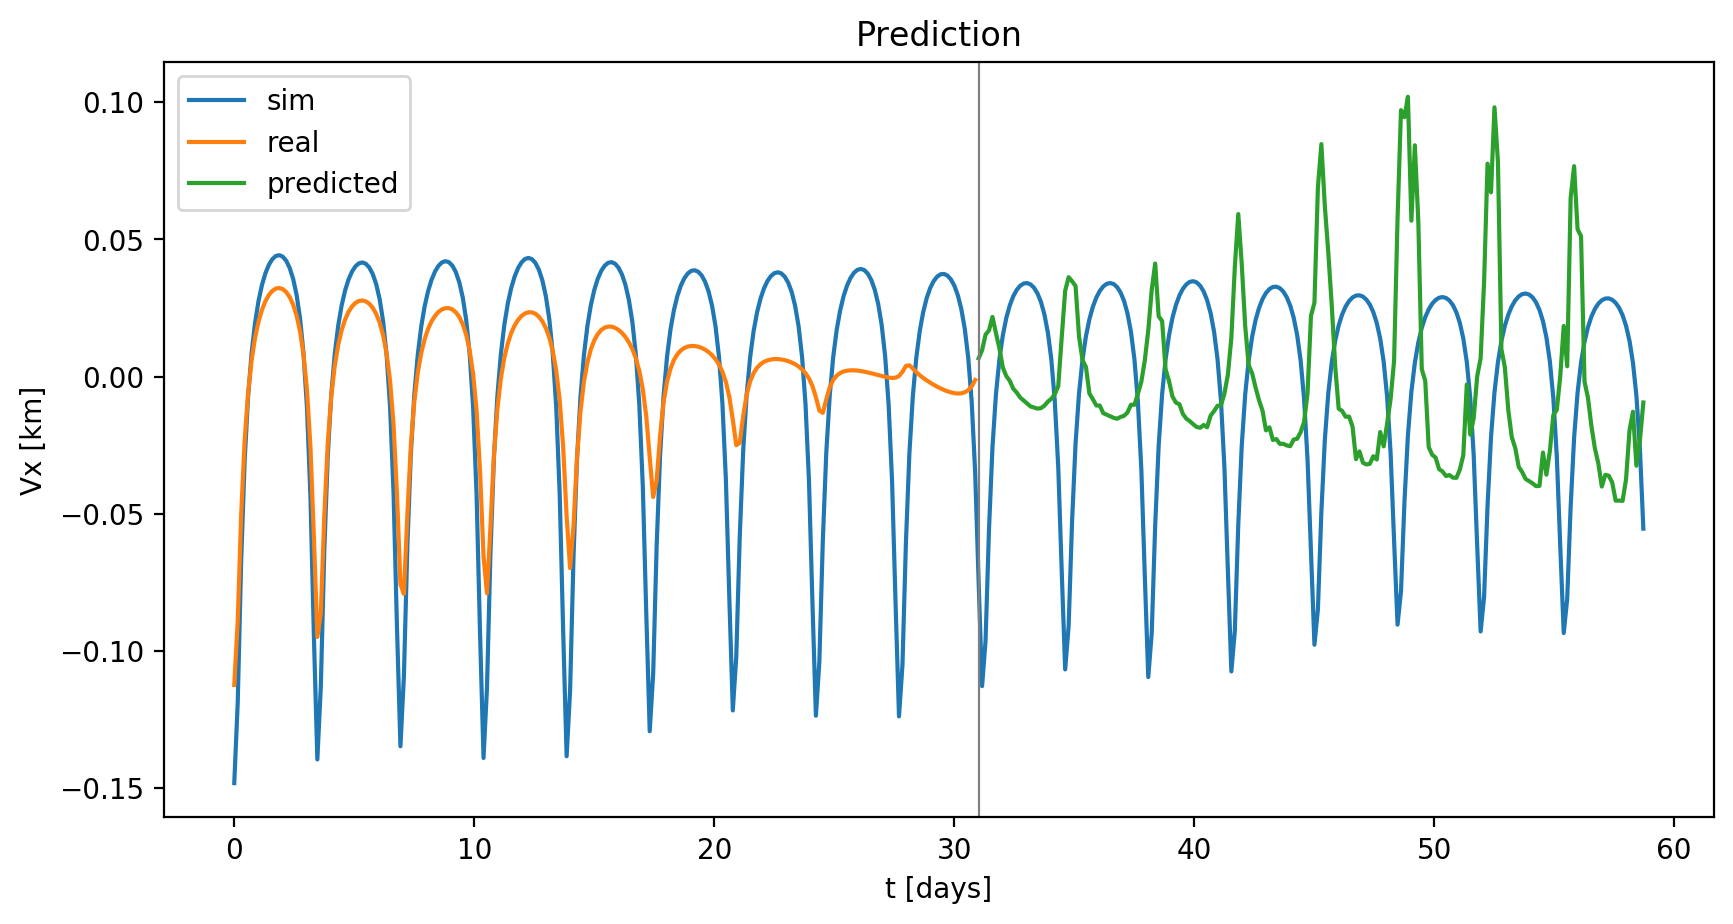

In [308]:
for sat_id in tqdm([310]):
    try:
        sat_data = utils.get_satellite_data(data, sat_id).reset_index(drop=True)
        sat_data = utils.remove_time_jumps_fast(sat_data)
        
#         N = 4*len(utils.get_satellite_data(train_data, sat_id)['epoch'])//5
        train_t = utils.get_satellite_data(train_data, sat_id)['epoch'].iloc[:N]
        test_t = pd.concat([utils.get_satellite_data(train_data, sat_id)['epoch'].iloc[N:], utils.get_satellite_data(test_data, sat_id)['epoch'].iloc[:]])

        pred_dfs = []
        sparse_pred_dfs = []
        # running sine_alignment for different lattices:
        # different alphas and anchor features
        for anchor in state_cols:
            for alpha in np.linspace(0, 1, 100)[1:]:
                pred_df = na.sine_alignment(sat_data, sat_id, na.ShiftZeroKeypointsGenerator(anchor, alpha), train_t.max())
                sparse_pred_dfs.append(pred_df)
        sparse_pred = pd.concat(sparse_pred_dfs).sort_values('epoch').reset_index(drop=True)
        dense_pred = na.sparse_pred_to_dense(sparse_pred, test_t, dt=8)
        all_predictions_shiftzero_kp[sat_id] = dense_pred
    except Exception as e:
        print(e)
        
t = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch'])[0]) /
                 np.timedelta64(1, 'D')).astype(float)
plt.figure(figsize = (10,5), dpi = 200)
plt.plot(t, sat_data.Vx_sim, label = 'sim')
plt.plot(t[:len(sat_data.x)], sat_data.Vx, label = 'real')
plt.plot(t[len(train_t):], dense_pred.Vx, label ='predicted')
_ = plt.legend()
_ = plt.xlabel('t [days]')
_ = plt.ylabel('Vx [km]')
_ = plt.title('Prediction')
# _ = plt.xlim([0,32])
_ = plt.axvline(x=t[len(train_t)], color = 'gray', linewidth = 0.8)